In [ ]:
import kagglehub
# Download latest version

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)
print(path)

ModuleNotFoundError: No module named 'kagglehub'

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=2090x1858 at 0x7D9D2C0FE200>


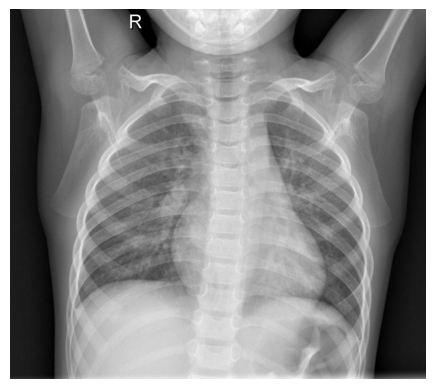

In [ ]:
from PIL import Image
import os


import matplotlib.pyplot as plt

image = Image.open(os.path.join(path, "chest_xray/train/NORMAL/IM-0115-0001.jpeg"))

print(image)


plt.imshow(image, cmap = 'gray')
plt.axis('off')  # This removes the axes
plt.show()


# TODO: Transform the datase to




In [ ]:
import numpy as np
#Folder is either test, train, val
def load_images_from_folder(folder, image_size):

    #Define paths to normal and pneumonia
    normal =os.path.join(path, "chest_xray", folder, "NORMAL")
    pneumonia = os.path.join(path, "chest_xray", folder, "PNEUMONIA")


    x, y = [], []
    for img in os.listdir(normal):
        img_path = os.path.join(normal, img)
        try:
          img = Image.open(img_path)
          img = Image.open(img_path).convert("L") #Convert to grayscale
          img = img.resize((image_size, image_size))
          img_array = np.array(img)
          x.append(img_array)
          y.append(0)
        except Exception as e:
          print(f"Error loading image {img_path}: {e}")

    for img in os.listdir(pneumonia):
      img_path = os.path.join(pneumonia,img)
      try:
        img = Image.open(img_path)
        img = Image.open(img_path).convert("L") #Convert to grayscale
        img = img.resize((image_size, image_size))
        x.append(img_array)
        y.append(1)
      except Exception as e:
        print(f"Error loading image {img_path}: {e}")

    x = np.array(x)
    y = np.array(y)
    return x, y


In [ ]:
x_train, y_train = load_images_from_folder("train", 256)
x_test, y_test = load_images_from_folder("test", 256)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5216, 256, 256)
(5216,)
(624, 256, 256)
(624,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from typing import Tuple # Class for reinforcing output requriements


class CustomDataset(Dataset):
    """Custom Dataset for loading image data and labels"""
    def __init__(self, X: np.ndarray, y: np.ndarray, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

        # TODO: Define specific desired tranformations needed
        self.transform = transform

        # Add channel dimension if not present --> NOTE: This function unsqueezes the tensor to be a different shape.
        if len(self.X.shape) == 3:  # (n, height, width)
            self.X = self.X.unsqueeze(1)  # (n, 1, height, width)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = self.X[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Model defining basic CNN block - for

class SimpleCNN(nn.Module):
    """Basic CNN architecture for classification"""
    def __init__(self, input_channels: int, num_classes: int, dropout_rate: float = 0.5):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )

        # Calculate size of flattened features
        self.feature_size = self._get_flat_size()


        self.classifier = nn.Sequential(

            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def _get_flat_size(self) -> int:
        # Helper function to calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)  # Adjust size based on your input
            output = self.features(dummy_input)
            return int(np.prod(output.size()[1:]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the 2d convolution map
        x = self.classifier(x)
        return x


# is this for each element?
def collate_fn(batch):
    batch = dict()
    images = torch.stack([batch[0]], axis = 0)
    labels = torch.stack([batch[1]])

    return batch

dataset = CustomDataset(X_train, y_train, transform = None)
dataloader = DataLoader(dataset, batch_size = 64, collate_fn = None)


